In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(463113, 828)
(463113, 1)
validation
(87055, 828)
(87055, 1)
test
(43409, 828)
(43409, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/47 [..............................] - ETA: 1:12 - loss: 0.0484 - STD: 1.8434e-04 - MAE: 0.2101

 4/47 [=>............................] - ETA: 1s - loss: 0.0318 - STD: 2.7357e-04 - MAE: 0.1322  

 5/47 [==>...........................] - ETA: 1s - loss: 0.0319 - STD: 2.5886e-04 - MAE: 0.1314

 6/47 [==>...........................] - ETA: 1s - loss: 0.0313 - STD: 2.4915e-04 - MAE: 0.1284

 7/47 [===>..........................] - ETA: 1s - loss: 0.0301 - STD: 2.4846e-04 - MAE: 0.1230

 8/47 [====>.........................] - ETA: 2s - loss: 0.0286 - STD: 2.5548e-04 - MAE: 0.1169

 9/47 [====>.........................] - ETA: 2s - loss: 0.0273 - STD: 2.6774e-04 - MAE: 0.1136

10/47 [=====>........................] - ETA: 2s - loss: 0.0264 - STD: 2.8281e-04 - MAE: 0.1134

11/47 [======>.......................] - ETA: 2s - loss: 0.0259 - STD: 2.9883e-04 - MAE: 0.1147

12/47 [======>.......................] - ETA: 2s - loss: 0.0257 - STD: 3.1508e-04 - MAE: 0.1163

13/47 [=======>......................] - ETA: 1s - loss: 0.0253 - STD: 3.3094e-04 - MAE: 0.1170

14/47 [=======>......................] - ETA: 1s - loss: 0.0248 - STD: 3.4639e-04 - MAE: 0.1166

15/47 [========>.....................] - ETA: 1s - loss: 0.0243 - STD: 3.6056e-04 - MAE: 0.1152

16/47 [=========>....................] - ETA: 1s - loss: 0.0238 - STD: 3.7324e-04 - MAE: 0.1131

17/47 [=========>....................] - ETA: 1s - loss: 0.0234 - STD: 3.8454e-04 - MAE: 0.1109

18/47 [==========>...................] - ETA: 2s - loss: 0.0233 - STD: 3.9474e-04 - MAE: 0.1089

21/47 [============>.................] - ETA: 2s - loss: 0.0226 - STD: 4.2480e-04 - MAE: 0.1040

23/47 [=============>................] - ETA: 1s - loss: 0.0221 - STD: 4.4917e-04 - MAE: 0.1016

24/47 [==============>...............] - ETA: 1s - loss: 0.0219 - STD: 4.6295e-04 - MAE: 0.1008

25/47 [==============>...............] - ETA: 1s - loss: 0.0217 - STD: 4.7741e-04 - MAE: 0.1003

26/47 [===============>..............] - ETA: 1s - loss: 0.0215 - STD: 4.9321e-04 - MAE: 0.1001

27/47 [================>.............] - ETA: 1s - loss: 0.0213 - STD: 5.0990e-04 - MAE: 0.1001

28/47 [================>.............] - ETA: 1s - loss: 0.0211 - STD: 5.2666e-04 - MAE: 0.1001

29/47 [=================>............] - ETA: 1s - loss: 0.0210 - STD: 5.4385e-04 - MAE: 0.1002

30/47 [==================>...........] - ETA: 1s - loss: 0.0209 - STD: 5.6098e-04 - MAE: 0.1002

31/47 [==================>...........] - ETA: 1s - loss: 0.0208 - STD: 5.7832e-04 - MAE: 0.1000

32/47 [===================>..........] - ETA: 1s - loss: 0.0206 - STD: 5.9583e-04 - MAE: 0.0996

33/47 [====================>.........] - ETA: 1s - loss: 0.0205 - STD: 6.1330e-04 - MAE: 0.0991

34/47 [====================>.........] - ETA: 0s - loss: 0.0204 - STD: 6.3080e-04 - MAE: 0.0985

35/47 [=====================>........] - ETA: 0s - loss: 0.0203 - STD: 6.4913e-04 - MAE: 0.0979

36/47 [=====================>........] - ETA: 0s - loss: 0.0202 - STD: 6.6799e-04 - MAE: 0.0973

37/47 [======================>.......] - ETA: 0s - loss: 0.0201 - STD: 6.8779e-04 - MAE: 0.0968

38/47 [=======================>......] - ETA: 0s - loss: 0.0200 - STD: 7.0871e-04 - MAE: 0.0963

39/47 [=======================>......] - ETA: 0s - loss: 0.0199 - STD: 7.3159e-04 - MAE: 0.0958

40/47 [========================>.....] - ETA: 0s - loss: 0.0198 - STD: 7.5578e-04 - MAE: 0.0955

41/47 [=========================>....] - ETA: 0s - loss: 0.0197 - STD: 7.8268e-04 - MAE: 0.0953

42/47 [=========================>....] - ETA: 0s - loss: 0.0196 - STD: 8.1077e-04 - MAE: 0.0951

43/47 [==========================>...] - ETA: 0s - loss: 0.0195 - STD: 8.4094e-04 - MAE: 0.0950

44/47 [===========================>..] - ETA: 0s - loss: 0.0194 - STD: 8.7352e-04 - MAE: 0.0949

45/47 [===========================>..] - ETA: 0s - loss: 0.0194 - STD: 9.0731e-04 - MAE: 0.0948

46/47 [============================>.] - ETA: 0s - loss: 0.0193 - STD: 9.4335e-04 - MAE: 0.0946

47/47 [==============================] - ETA: 0s - loss: 0.0192 - STD: 9.8130e-04 - MAE: 0.0945

47/47 [==============================] - 6s 90ms/step - loss: 0.0192 - STD: 9.8130e-04 - MAE: 0.0945 - val_loss: 0.0184 - val_STD: 0.0023 - val_MAE: 0.0908


Epoch 2/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0158 - STD: 0.0029 - MAE: 0.0836

 2/47 [>.............................] - ETA: 3s - loss: 0.0157 - STD: 0.0030 - MAE: 0.0827

 3/47 [>.............................] - ETA: 3s - loss: 0.0159 - STD: 0.0031 - MAE: 0.0824

 4/47 [=>............................] - ETA: 3s - loss: 0.0160 - STD: 0.0032 - MAE: 0.0819

 5/47 [==>...........................] - ETA: 2s - loss: 0.0160 - STD: 0.0033 - MAE: 0.0816

 6/47 [==>...........................] - ETA: 2s - loss: 0.0160 - STD: 0.0035 - MAE: 0.0815

 7/47 [===>..........................] - ETA: 2s - loss: 0.0160 - STD: 0.0036 - MAE: 0.0817

 8/47 [====>.........................] - ETA: 2s - loss: 0.0161 - STD: 0.0038 - MAE: 0.0820

 9/47 [====>.........................] - ETA: 2s - loss: 0.0159 - STD: 0.0040 - MAE: 0.0821

10/47 [=====>........................] - ETA: 2s - loss: 0.0158 - STD: 0.0042 - MAE: 0.0822

11/47 [======>.......................] - ETA: 2s - loss: 0.0158 - STD: 0.0044 - MAE: 0.0825

12/47 [======>.......................] - ETA: 2s - loss: 0.0157 - STD: 0.0046 - MAE: 0.0826

13/47 [=======>......................] - ETA: 2s - loss: 0.0157 - STD: 0.0048 - MAE: 0.0826

14/47 [=======>......................] - ETA: 2s - loss: 0.0157 - STD: 0.0051 - MAE: 0.0826

15/47 [========>.....................] - ETA: 2s - loss: 0.0156 - STD: 0.0054 - MAE: 0.0825

16/47 [=========>....................] - ETA: 2s - loss: 0.0156 - STD: 0.0057 - MAE: 0.0824

17/47 [=========>....................] - ETA: 2s - loss: 0.0156 - STD: 0.0060 - MAE: 0.0822

19/47 [===========>..................] - ETA: 1s - loss: 0.0155 - STD: 0.0067 - MAE: 0.0818

20/47 [===========>..................] - ETA: 1s - loss: 0.0154 - STD: 0.0071 - MAE: 0.0816

21/47 [============>.................] - ETA: 1s - loss: 0.0153 - STD: 0.0076 - MAE: 0.0815

22/47 [=============>................] - ETA: 1s - loss: 0.0153 - STD: 0.0081 - MAE: 0.0813

23/47 [=============>................] - ETA: 1s - loss: 0.0152 - STD: 0.0087 - MAE: 0.0811

24/47 [==============>...............] - ETA: 1s - loss: 0.0151 - STD: 0.0093 - MAE: 0.0809

25/47 [==============>...............] - ETA: 1s - loss: 0.0150 - STD: 0.0100 - MAE: 0.0807

26/47 [===============>..............] - ETA: 1s - loss: 0.0149 - STD: 0.0107 - MAE: 0.0804

27/47 [================>.............] - ETA: 1s - loss: 0.0148 - STD: 0.0116 - MAE: 0.0801

28/47 [================>.............] - ETA: 1s - loss: 0.0146 - STD: 0.0124 - MAE: 0.0797

29/47 [=================>............] - ETA: 1s - loss: 0.0145 - STD: 0.0134 - MAE: 0.0792

30/47 [==================>...........] - ETA: 1s - loss: 0.0144 - STD: 0.0144 - MAE: 0.0788

31/47 [==================>...........] - ETA: 1s - loss: 0.0142 - STD: 0.0155 - MAE: 0.0784

32/47 [===================>..........] - ETA: 0s - loss: 0.0141 - STD: 0.0168 - MAE: 0.0779

33/47 [====================>.........] - ETA: 0s - loss: 0.0139 - STD: 0.0180 - MAE: 0.0775

34/47 [====================>.........] - ETA: 0s - loss: 0.0137 - STD: 0.0194 - MAE: 0.0770

35/47 [=====================>........] - ETA: 0s - loss: 0.0136 - STD: 0.0208 - MAE: 0.0766

36/47 [=====================>........] - ETA: 0s - loss: 0.0134 - STD: 0.0223 - MAE: 0.0761

37/47 [======================>.......] - ETA: 0s - loss: 0.0133 - STD: 0.0238 - MAE: 0.0756

38/47 [=======================>......] - ETA: 0s - loss: 0.0131 - STD: 0.0254 - MAE: 0.0752

39/47 [=======================>......] - ETA: 0s - loss: 0.0130 - STD: 0.0270 - MAE: 0.0747

40/47 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 0.0285 - MAE: 0.0743

41/47 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 0.0300 - MAE: 0.0738

42/47 [=========================>....] - ETA: 0s - loss: 0.0125 - STD: 0.0315 - MAE: 0.0734

43/47 [==========================>...] - ETA: 0s - loss: 0.0124 - STD: 0.0330 - MAE: 0.0730

44/47 [===========================>..] - ETA: 0s - loss: 0.0123 - STD: 0.0345 - MAE: 0.0725

45/47 [===========================>..] - ETA: 0s - loss: 0.0121 - STD: 0.0358 - MAE: 0.0721

46/47 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 0.0371 - MAE: 0.0717

47/47 [==============================] - ETA: 0s - loss: 0.0119 - STD: 0.0384 - MAE: 0.0713

47/47 [==============================] - 3s 71ms/step - loss: 0.0119 - STD: 0.0384 - MAE: 0.0713 - val_loss: 0.0077 - val_STD: 0.0931 - val_MAE: 0.0610


Epoch 3/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0063 - STD: 0.1005 - MAE: 0.0525

 2/47 [>.............................] - ETA: 2s - loss: 0.0062 - STD: 0.1004 - MAE: 0.0523

 3/47 [>.............................] - ETA: 2s - loss: 0.0061 - STD: 0.0996 - MAE: 0.0519

 4/47 [=>............................] - ETA: 2s - loss: 0.0061 - STD: 0.0991 - MAE: 0.0517

 6/47 [==>...........................] - ETA: 2s - loss: 0.0061 - STD: 0.1005 - MAE: 0.0519

 7/47 [===>..........................] - ETA: 2s - loss: 0.0060 - STD: 0.1015 - MAE: 0.0518

 8/47 [====>.........................] - ETA: 2s - loss: 0.0060 - STD: 0.1021 - MAE: 0.0516

 9/47 [====>.........................] - ETA: 2s - loss: 0.0059 - STD: 0.1022 - MAE: 0.0512

10/47 [=====>........................] - ETA: 2s - loss: 0.0059 - STD: 0.1024 - MAE: 0.0509

11/47 [======>.......................] - ETA: 2s - loss: 0.0058 - STD: 0.1031 - MAE: 0.0508

12/47 [======>.......................] - ETA: 2s - loss: 0.0058 - STD: 0.1036 - MAE: 0.0506

13/47 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.1040 - MAE: 0.0504

14/47 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.1042 - MAE: 0.0502

15/47 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.1042 - MAE: 0.0500

16/47 [=========>....................] - ETA: 1s - loss: 0.0055 - STD: 0.1041 - MAE: 0.0498

17/47 [=========>....................] - ETA: 1s - loss: 0.0055 - STD: 0.1042 - MAE: 0.0496

18/47 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.1044 - MAE: 0.0494

19/47 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.1046 - MAE: 0.0493

20/47 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.1045 - MAE: 0.0491

21/47 [============>.................] - ETA: 1s - loss: 0.0053 - STD: 0.1045 - MAE: 0.0489

22/47 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.1045 - MAE: 0.0488

23/47 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.1047 - MAE: 0.0486

24/47 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.1049 - MAE: 0.0485

25/47 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.1049 - MAE: 0.0483

26/47 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.1049 - MAE: 0.0482

27/47 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.1050 - MAE: 0.0481

28/47 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.1053 - MAE: 0.0479

29/47 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.1054 - MAE: 0.0478

30/47 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.1055 - MAE: 0.0477

31/47 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.1056 - MAE: 0.0475

32/47 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.1059 - MAE: 0.0474

33/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.1061 - MAE: 0.0473

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.1061 - MAE: 0.0472

35/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.1061 - MAE: 0.0471

36/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.1063 - MAE: 0.0470

37/47 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.1065 - MAE: 0.0469

38/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.1066 - MAE: 0.0468

39/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.1066 - MAE: 0.0467

40/47 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.1066 - MAE: 0.0466

41/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.1070 - MAE: 0.0465

42/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.1071 - MAE: 0.0464

43/47 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.1072 - MAE: 0.0463

44/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.1073 - MAE: 0.0463

45/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.1075 - MAE: 0.0462

46/47 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.1076 - MAE: 0.0461

47/47 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.1076 - MAE: 0.0460

47/47 [==============================] - 3s 71ms/step - loss: 0.0046 - STD: 0.1076 - MAE: 0.0460 - val_loss: 0.0038 - val_STD: 0.0989 - val_MAE: 0.0430


Epoch 4/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.1057 - MAE: 0.0417

 2/47 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.1088 - MAE: 0.0419

 3/47 [>.............................] - ETA: 2s - loss: 0.0039 - STD: 0.1122 - MAE: 0.0420

 4/47 [=>............................] - ETA: 2s - loss: 0.0038 - STD: 0.1116 - MAE: 0.0418

 5/47 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.1101 - MAE: 0.0418

 6/47 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.1102 - MAE: 0.0417

 7/47 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.1116 - MAE: 0.0418

 8/47 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.1116 - MAE: 0.0417

 9/47 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.1113 - MAE: 0.0416

10/47 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.1117 - MAE: 0.0415

11/47 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.1122 - MAE: 0.0415

12/47 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.1120 - MAE: 0.0414

13/47 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.1115 - MAE: 0.0414

14/47 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.1115 - MAE: 0.0413

15/47 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.1118 - MAE: 0.0414

16/47 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.1118 - MAE: 0.0414

17/47 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.1115 - MAE: 0.0414

18/47 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.1115 - MAE: 0.0413

20/47 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.1119 - MAE: 0.0413

21/47 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.1118 - MAE: 0.0413

22/47 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.1119 - MAE: 0.0413

23/47 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.1121 - MAE: 0.0413

24/47 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.1122 - MAE: 0.0413

25/47 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.1121 - MAE: 0.0412

26/47 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.1121 - MAE: 0.0412

27/47 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.1124 - MAE: 0.0412

28/47 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.1125 - MAE: 0.0411

29/47 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.1122 - MAE: 0.0411

30/47 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.1122 - MAE: 0.0411

31/47 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.1124 - MAE: 0.0411

32/47 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.1124 - MAE: 0.0411

33/47 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.1124 - MAE: 0.0410

34/47 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.1124 - MAE: 0.0410

35/47 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.1125 - MAE: 0.0410

36/47 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.1125 - MAE: 0.0410

37/47 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.1124 - MAE: 0.0409

38/47 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.1125 - MAE: 0.0409

39/47 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.1126 - MAE: 0.0409

40/47 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.1127 - MAE: 0.0408

41/47 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.1126 - MAE: 0.0408

42/47 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.1127 - MAE: 0.0407

43/47 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.1128 - MAE: 0.0407

44/47 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.1128 - MAE: 0.0407

45/47 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.1128 - MAE: 0.0407

46/47 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.1127 - MAE: 0.0406

47/47 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.1128 - MAE: 0.0406

47/47 [==============================] - 3s 71ms/step - loss: 0.0035 - STD: 0.1128 - MAE: 0.0406 - val_loss: 0.0037 - val_STD: 0.1047 - val_MAE: 0.0440


Epoch 5/10000


 1/47 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.1156 - MAE: 0.0387

 2/47 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.1139 - MAE: 0.0388

 3/47 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.1142 - MAE: 0.0390

 4/47 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.1140 - MAE: 0.0391

 5/47 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.1145 - MAE: 0.0391

 6/47 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.1145 - MAE: 0.0391

 7/47 [===>..........................] - ETA: 2s - loss: 0.0033 - STD: 0.1141 - MAE: 0.0390

 8/47 [====>.........................] - ETA: 2s - loss: 0.0033 - STD: 0.1141 - MAE: 0.0391

 9/47 [====>.........................] - ETA: 2s - loss: 0.0033 - STD: 0.1141 - MAE: 0.0391

10/47 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.1141 - MAE: 0.0392

11/47 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.1143 - MAE: 0.0392

12/47 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.1140 - MAE: 0.0391

13/47 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.1140 - MAE: 0.0391

14/47 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.1142 - MAE: 0.0391

15/47 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.1143 - MAE: 0.0391

16/47 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.1143 - MAE: 0.0392

17/47 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.1144 - MAE: 0.0392

18/47 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.1146 - MAE: 0.0392

19/47 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.1145 - MAE: 0.0392

20/47 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.1145 - MAE: 0.0391

21/47 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.1146 - MAE: 0.0391

22/47 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.1145 - MAE: 0.0391

23/47 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.1143 - MAE: 0.0391

24/47 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.1144 - MAE: 0.0391

26/47 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.1143 - MAE: 0.0391

27/47 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.1142 - MAE: 0.0391

28/47 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.1144 - MAE: 0.0391

29/47 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.1144 - MAE: 0.0391

30/47 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.1143 - MAE: 0.0391

31/47 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.1143 - MAE: 0.0391

32/47 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.1145 - MAE: 0.0391

33/47 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.1144 - MAE: 0.0390

34/47 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.1144 - MAE: 0.0390

35/47 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.1144 - MAE: 0.0390

36/47 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.1145 - MAE: 0.0391

37/47 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.1143 - MAE: 0.0391

38/47 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.1143 - MAE: 0.0390

39/47 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.1144 - MAE: 0.0390

40/47 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1144 - MAE: 0.0390

41/47 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1142 - MAE: 0.0390

42/47 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1142 - MAE: 0.0390

43/47 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1143 - MAE: 0.0390

44/47 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1142 - MAE: 0.0390

45/47 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.1142 - MAE: 0.0390

46/47 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.1142 - MAE: 0.0390

47/47 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.1143 - MAE: 0.0390

47/47 [==============================] - 3s 72ms/step - loss: 0.0032 - STD: 0.1143 - MAE: 0.0390 - val_loss: 0.0036 - val_STD: 0.1046 - val_MAE: 0.0436


Epoch 6/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.1140 - MAE: 0.0379

 2/47 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.1147 - MAE: 0.0381

 3/47 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.1149 - MAE: 0.0382

 4/47 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.1153 - MAE: 0.0380

 5/47 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.1146 - MAE: 0.0382

 6/47 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.1154 - MAE: 0.0382

 7/47 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.1156 - MAE: 0.0382

 9/47 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.1151 - MAE: 0.0381

10/47 [=====>........................] - ETA: 2s - loss: 0.0031 - STD: 0.1153 - MAE: 0.0381

11/47 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.1150 - MAE: 0.0380

12/47 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.1148 - MAE: 0.0381

13/47 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.1150 - MAE: 0.0380

14/47 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.1150 - MAE: 0.0380

15/47 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.1149 - MAE: 0.0380

16/47 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.1148 - MAE: 0.0379

17/47 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.1149 - MAE: 0.0379

18/47 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.1148 - MAE: 0.0380

19/47 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.1148 - MAE: 0.0379

20/47 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.1149 - MAE: 0.0380

21/47 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.1150 - MAE: 0.0380

22/47 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.1150 - MAE: 0.0380

23/47 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.1152 - MAE: 0.0380

24/47 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1152 - MAE: 0.0380

25/47 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1151 - MAE: 0.0380

26/47 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.1150 - MAE: 0.0379

27/47 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.1151 - MAE: 0.0380

28/47 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.1152 - MAE: 0.0380

29/47 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.1152 - MAE: 0.0379

30/47 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.1152 - MAE: 0.0379

31/47 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.1153 - MAE: 0.0379

32/47 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.1153 - MAE: 0.0379

33/47 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.1152 - MAE: 0.0379

34/47 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.1152 - MAE: 0.0379

35/47 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1153 - MAE: 0.0379

36/47 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1152 - MAE: 0.0379

37/47 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1152 - MAE: 0.0379

38/47 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1152 - MAE: 0.0379

39/47 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1151 - MAE: 0.0379

40/47 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1151 - MAE: 0.0379

41/47 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1152 - MAE: 0.0379

42/47 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1152 - MAE: 0.0378

43/47 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1151 - MAE: 0.0378

44/47 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1152 - MAE: 0.0379

45/47 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1151 - MAE: 0.0378

46/47 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1151 - MAE: 0.0378

47/47 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1152 - MAE: 0.0378

47/47 [==============================] - 3s 72ms/step - loss: 0.0031 - STD: 0.1152 - MAE: 0.0378 - val_loss: 0.0034 - val_STD: 0.1057 - val_MAE: 0.0431


Epoch 7/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.1159 - MAE: 0.0374

 2/47 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.1144 - MAE: 0.0372

 3/47 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.1156 - MAE: 0.0376

 4/47 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.1153 - MAE: 0.0376

 5/47 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.1153 - MAE: 0.0376

 6/47 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.1159 - MAE: 0.0376

 7/47 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.1153 - MAE: 0.0376

 8/47 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.1150 - MAE: 0.0376

 9/47 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.1153 - MAE: 0.0376

10/47 [=====>........................] - ETA: 2s - loss: 0.0030 - STD: 0.1149 - MAE: 0.0377

11/47 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.1148 - MAE: 0.0377

12/47 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.1153 - MAE: 0.0378

13/47 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.1147 - MAE: 0.0378

14/47 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.1148 - MAE: 0.0377

15/47 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.1152 - MAE: 0.0378

16/47 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.1150 - MAE: 0.0379

17/47 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.1152 - MAE: 0.0378

18/47 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.1156 - MAE: 0.0378

19/47 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.1155 - MAE: 0.0378

20/47 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.1155 - MAE: 0.0377

21/47 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.1157 - MAE: 0.0378

22/47 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.1156 - MAE: 0.0378

23/47 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.1154 - MAE: 0.0378

24/47 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.1155 - MAE: 0.0377

25/47 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.1157 - MAE: 0.0378

26/47 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.1156 - MAE: 0.0377

27/47 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.1155 - MAE: 0.0377

28/47 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.1156 - MAE: 0.0377

29/47 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.1156 - MAE: 0.0376

30/47 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.1155 - MAE: 0.0376

31/47 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.1155 - MAE: 0.0376

32/47 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.1155 - MAE: 0.0376

33/47 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.1155 - MAE: 0.0376

34/47 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.1156 - MAE: 0.0376

35/47 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1155 - MAE: 0.0376

37/47 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.1156 - MAE: 0.0375

38/47 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.1156 - MAE: 0.0375

39/47 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.1155 - MAE: 0.0375

40/47 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.1156 - MAE: 0.0375

41/47 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1157 - MAE: 0.0374

42/47 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1156 - MAE: 0.0374

43/47 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1157 - MAE: 0.0374

44/47 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1156 - MAE: 0.0374

45/47 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1156 - MAE: 0.0374

46/47 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1157 - MAE: 0.0374

47/47 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1157 - MAE: 0.0373

47/47 [==============================] - 3s 71ms/step - loss: 0.0030 - STD: 0.1157 - MAE: 0.0373 - val_loss: 0.0031 - val_STD: 0.1034 - val_MAE: 0.0415


Epoch 8/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.1132 - MAE: 0.0367

 2/47 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.1170 - MAE: 0.0373

 3/47 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.1152 - MAE: 0.0374

 4/47 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.1153 - MAE: 0.0372

 5/47 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.1167 - MAE: 0.0374

 6/47 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.1157 - MAE: 0.0373

 7/47 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.1159 - MAE: 0.0371

 8/47 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.1163 - MAE: 0.0372

 9/47 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.1153 - MAE: 0.0372

10/47 [=====>........................] - ETA: 2s - loss: 0.0030 - STD: 0.1157 - MAE: 0.0372

11/47 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.1161 - MAE: 0.0373

12/47 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.1156 - MAE: 0.0374

13/47 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.1159 - MAE: 0.0373

14/47 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.1164 - MAE: 0.0373

15/47 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.1160 - MAE: 0.0374

16/47 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.1161 - MAE: 0.0374

17/47 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.1163 - MAE: 0.0374

18/47 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.1160 - MAE: 0.0374

19/47 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.1161 - MAE: 0.0374

20/47 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.1162 - MAE: 0.0374

22/47 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.1162 - MAE: 0.0373

23/47 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.1163 - MAE: 0.0374

24/47 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.1162 - MAE: 0.0373

25/47 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.1161 - MAE: 0.0373

26/47 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.1161 - MAE: 0.0373

27/47 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.1161 - MAE: 0.0373

28/47 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.1160 - MAE: 0.0372

29/47 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.1160 - MAE: 0.0372

30/47 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.1160 - MAE: 0.0372

31/47 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.1160 - MAE: 0.0372

32/47 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.1161 - MAE: 0.0371

33/47 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1160 - MAE: 0.0371

34/47 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1161 - MAE: 0.0371

35/47 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1161 - MAE: 0.0371

36/47 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1160 - MAE: 0.0371

37/47 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1160 - MAE: 0.0370

38/47 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1160 - MAE: 0.0370

39/47 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1160 - MAE: 0.0370

40/47 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1161 - MAE: 0.0370

41/47 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1162 - MAE: 0.0370

42/47 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1161 - MAE: 0.0370

43/47 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1162 - MAE: 0.0370

44/47 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1162 - MAE: 0.0370

45/47 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1162 - MAE: 0.0370

46/47 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1162 - MAE: 0.0369

47/47 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1161 - MAE: 0.0369

47/47 [==============================] - 3s 72ms/step - loss: 0.0029 - STD: 0.1161 - MAE: 0.0369 - val_loss: 0.0029 - val_STD: 0.1054 - val_MAE: 0.0404


Epoch 9/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.1171 - MAE: 0.0364

 2/47 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.1156 - MAE: 0.0363

 3/47 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.1153 - MAE: 0.0364

 4/47 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.1164 - MAE: 0.0364

 5/47 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.1158 - MAE: 0.0365

 6/47 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.1157 - MAE: 0.0365

 7/47 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.1161 - MAE: 0.0364

 8/47 [====>.........................] - ETA: 2s - loss: 0.0029 - STD: 0.1164 - MAE: 0.0364

 9/47 [====>.........................] - ETA: 2s - loss: 0.0029 - STD: 0.1158 - MAE: 0.0366

10/47 [=====>........................] - ETA: 2s - loss: 0.0029 - STD: 0.1167 - MAE: 0.0368

11/47 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.1167 - MAE: 0.0367

12/47 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.1164 - MAE: 0.0366

14/47 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.1164 - MAE: 0.0367

15/47 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.1162 - MAE: 0.0367

16/47 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.1165 - MAE: 0.0367

17/47 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.1163 - MAE: 0.0367

18/47 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.1164 - MAE: 0.0367

19/47 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.1166 - MAE: 0.0367

20/47 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.1162 - MAE: 0.0367

21/47 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.1162 - MAE: 0.0367

22/47 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.1165 - MAE: 0.0367

23/47 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.1162 - MAE: 0.0367

24/47 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1162 - MAE: 0.0367

25/47 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1163 - MAE: 0.0367

26/47 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.1162 - MAE: 0.0367

27/47 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.1163 - MAE: 0.0367

28/47 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.1164 - MAE: 0.0367

29/47 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.1162 - MAE: 0.0367

30/47 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.1163 - MAE: 0.0367

31/47 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.1162 - MAE: 0.0367

32/47 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.1161 - MAE: 0.0367

33/47 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1162 - MAE: 0.0367

34/47 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1161 - MAE: 0.0367

35/47 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1161 - MAE: 0.0366

36/47 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1162 - MAE: 0.0366

37/47 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1163 - MAE: 0.0366

38/47 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1163 - MAE: 0.0366

39/47 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1163 - MAE: 0.0366

40/47 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1163 - MAE: 0.0366

41/47 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1162 - MAE: 0.0365

42/47 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1163 - MAE: 0.0365

43/47 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1163 - MAE: 0.0365

44/47 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1162 - MAE: 0.0365

45/47 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1163 - MAE: 0.0366

46/47 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1163 - MAE: 0.0365

47/47 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1163 - MAE: 0.0365

47/47 [==============================] - 3s 72ms/step - loss: 0.0029 - STD: 0.1163 - MAE: 0.0365 - val_loss: 0.0028 - val_STD: 0.1092 - val_MAE: 0.0397


Epoch 10/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.1209 - MAE: 0.0365

 2/47 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0362

 3/47 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.1160 - MAE: 0.0359

 4/47 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.1158 - MAE: 0.0360

 5/47 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.1151 - MAE: 0.0360

 6/47 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.1159 - MAE: 0.0361

 7/47 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.1157 - MAE: 0.0360

 8/47 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.1160 - MAE: 0.0360

 9/47 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.1164 - MAE: 0.0361

10/47 [=====>........................] - ETA: 2s - loss: 0.0028 - STD: 0.1163 - MAE: 0.0360

11/47 [======>.......................] - ETA: 2s - loss: 0.0028 - STD: 0.1165 - MAE: 0.0360

12/47 [======>.......................] - ETA: 2s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0360

13/47 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0360

14/47 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0360

15/47 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0360

16/47 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.1165 - MAE: 0.0360

17/47 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.1165 - MAE: 0.0360

18/47 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0360

19/47 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.1164 - MAE: 0.0360

20/47 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0360

21/47 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0360

22/47 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0360

23/47 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.1165 - MAE: 0.0360

24/47 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0360

25/47 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0360

26/47 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0359

27/47 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0360

28/47 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.1165 - MAE: 0.0359

30/47 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.1164 - MAE: 0.0359

31/47 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.1163 - MAE: 0.0359

32/47 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.1164 - MAE: 0.0359

33/47 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1163 - MAE: 0.0359

34/47 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1165 - MAE: 0.0359

35/47 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0359

36/47 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0359

37/47 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1165 - MAE: 0.0359

38/47 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0359

39/47 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0359

40/47 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1165 - MAE: 0.0359

41/47 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0359

42/47 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0359

43/47 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0359

44/47 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0359

45/47 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0360

46/47 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0360

47/47 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0360

47/47 [==============================] - 3s 72ms/step - loss: 0.0028 - STD: 0.1167 - MAE: 0.0360 - val_loss: 0.0026 - val_STD: 0.1051 - val_MAE: 0.0377


Epoch 11/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.1179 - MAE: 0.0352

 2/47 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.1163 - MAE: 0.0360

 3/47 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.1180 - MAE: 0.0372

 4/47 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.1175 - MAE: 0.0372

 5/47 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.1173 - MAE: 0.0369

 6/47 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.1172 - MAE: 0.0368

 8/47 [====>.........................] - ETA: 2s - loss: 0.0029 - STD: 0.1165 - MAE: 0.0367

 9/47 [====>.........................] - ETA: 2s - loss: 0.0029 - STD: 0.1167 - MAE: 0.0365

10/47 [=====>........................] - ETA: 2s - loss: 0.0029 - STD: 0.1165 - MAE: 0.0365

11/47 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.1166 - MAE: 0.0366

12/47 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.1166 - MAE: 0.0366

13/47 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.1165 - MAE: 0.0365

14/47 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.1169 - MAE: 0.0365

15/47 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.1168 - MAE: 0.0364

16/47 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.1168 - MAE: 0.0363

17/47 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.1169 - MAE: 0.0364

18/47 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.1165 - MAE: 0.0365

19/47 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.1165 - MAE: 0.0364

20/47 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0364

21/47 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.1166 - MAE: 0.0365

22/47 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0365

23/47 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.1169 - MAE: 0.0364

24/47 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0365

25/47 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.1169 - MAE: 0.0365

26/47 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.1169 - MAE: 0.0364

27/47 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0364

28/47 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0364

29/47 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.1168 - MAE: 0.0364

30/47 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0365

31/47 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0365

32/47 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0365

33/47 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0365

34/47 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1168 - MAE: 0.0364

35/47 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0364

36/47 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0364

37/47 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0364

38/47 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0364

39/47 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1165 - MAE: 0.0364

40/47 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0364

41/47 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0363

42/47 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1165 - MAE: 0.0363

43/47 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0363

44/47 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0363

45/47 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1165 - MAE: 0.0363

46/47 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1166 - MAE: 0.0363

47/47 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1165 - MAE: 0.0363

47/47 [==============================] - 3s 71ms/step - loss: 0.0028 - STD: 0.1165 - MAE: 0.0363 - val_loss: 0.0026 - val_STD: 0.1048 - val_MAE: 0.0370


Epoch 12/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0353

 2/47 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.1176 - MAE: 0.0356

 3/47 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.1162 - MAE: 0.0358

 4/47 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.1172 - MAE: 0.0357

 5/47 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.1170 - MAE: 0.0356

 6/47 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.1163 - MAE: 0.0355

 7/47 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.1167 - MAE: 0.0355

 8/47 [====>.........................] - ETA: 2s - loss: 0.0027 - STD: 0.1168 - MAE: 0.0355

 9/47 [====>.........................] - ETA: 2s - loss: 0.0027 - STD: 0.1166 - MAE: 0.0355

10/47 [=====>........................] - ETA: 2s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0355

11/47 [======>.......................] - ETA: 2s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0355

12/47 [======>.......................] - ETA: 2s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0355

13/47 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1175 - MAE: 0.0355

14/47 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0356

15/47 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0356

16/47 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0356

17/47 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0356

18/47 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0356

19/47 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0356

20/47 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0356

21/47 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0356

22/47 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0355

23/47 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0355

24/47 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0355

25/47 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0355

26/47 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0355

28/47 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0355

29/47 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0355

30/47 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0355

31/47 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0355

32/47 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0355

33/47 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0355

34/47 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0355

35/47 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0355

36/47 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0355

37/47 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0355

38/47 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0355

39/47 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0355

40/47 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0355

41/47 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0355

42/47 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0355

43/47 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0355

44/47 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0355

45/47 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0355

46/47 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0355

47/47 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0355

47/47 [==============================] - 3s 71ms/step - loss: 0.0027 - STD: 0.1170 - MAE: 0.0355 - val_loss: 0.0025 - val_STD: 0.1093 - val_MAE: 0.0372


Epoch 13/10000


 1/47 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.1237 - MAE: 0.0362

 2/47 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.1179 - MAE: 0.0362

 3/47 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.1184 - MAE: 0.0364

 4/47 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.1175 - MAE: 0.0359

 5/47 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.1165 - MAE: 0.0358

 6/47 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.1170 - MAE: 0.0364

 7/47 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.1160 - MAE: 0.0366

 8/47 [====>.........................] - ETA: 2s - loss: 0.0029 - STD: 0.1168 - MAE: 0.0367

 9/47 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.1169 - MAE: 0.0365

10/47 [=====>........................] - ETA: 2s - loss: 0.0028 - STD: 0.1170 - MAE: 0.0364

11/47 [======>.......................] - ETA: 2s - loss: 0.0028 - STD: 0.1174 - MAE: 0.0364

12/47 [======>.......................] - ETA: 2s - loss: 0.0028 - STD: 0.1170 - MAE: 0.0364

13/47 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.1169 - MAE: 0.0363

14/47 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.1169 - MAE: 0.0362

15/47 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0362

16/47 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.1168 - MAE: 0.0362

17/47 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.1168 - MAE: 0.0361

18/47 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.1169 - MAE: 0.0361

19/47 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.1170 - MAE: 0.0360

20/47 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0360

21/47 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.1169 - MAE: 0.0360

22/47 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0360

23/47 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0360

25/47 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0359

26/47 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0359

27/47 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.1168 - MAE: 0.0359

28/47 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0359

29/47 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.1169 - MAE: 0.0359

30/47 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.1168 - MAE: 0.0358

31/47 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0358

32/47 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.1168 - MAE: 0.0359

33/47 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0359

34/47 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1168 - MAE: 0.0358

35/47 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1169 - MAE: 0.0359

36/47 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0359

37/47 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1169 - MAE: 0.0359

38/47 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1169 - MAE: 0.0359

39/47 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0359

40/47 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1168 - MAE: 0.0359

41/47 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0359

42/47 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0359

43/47 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1168 - MAE: 0.0358

44/47 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1168 - MAE: 0.0358

45/47 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1168 - MAE: 0.0358

46/47 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1170 - MAE: 0.0358

47/47 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1169 - MAE: 0.0358

47/47 [==============================] - 3s 71ms/step - loss: 0.0028 - STD: 0.1169 - MAE: 0.0358 - val_loss: 0.0024 - val_STD: 0.1067 - val_MAE: 0.0362


Epoch 14/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.1190 - MAE: 0.0355

 2/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1164 - MAE: 0.0351

 3/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1172 - MAE: 0.0351

 4/47 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0352

 5/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1171 - MAE: 0.0351

 7/47 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.1178 - MAE: 0.0353

 8/47 [====>.........................] - ETA: 2s - loss: 0.0027 - STD: 0.1174 - MAE: 0.0354

 9/47 [====>.........................] - ETA: 2s - loss: 0.0027 - STD: 0.1177 - MAE: 0.0353

10/47 [=====>........................] - ETA: 2s - loss: 0.0027 - STD: 0.1177 - MAE: 0.0352

11/47 [======>.......................] - ETA: 2s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0352

12/47 [======>.......................] - ETA: 2s - loss: 0.0027 - STD: 0.1175 - MAE: 0.0353

13/47 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1174 - MAE: 0.0353

14/47 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1174 - MAE: 0.0353

15/47 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.1175 - MAE: 0.0353

16/47 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0354

17/47 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0355

18/47 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0354

19/47 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.1169 - MAE: 0.0354

20/47 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0356

21/47 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.1169 - MAE: 0.0356

22/47 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0356

23/47 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0356

24/47 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1169 - MAE: 0.0357

25/47 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0357

26/47 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0357

27/47 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0356

28/47 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0356

29/47 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.1169 - MAE: 0.0356

30/47 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1169 - MAE: 0.0356

31/47 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0357

32/47 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0357

33/47 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0357

34/47 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0356

35/47 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0356

36/47 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0356

37/47 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0356

38/47 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0356

39/47 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0356

40/47 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0356

41/47 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0355

42/47 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0355

43/47 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0355

44/47 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0355

45/47 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0355

46/47 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0355

47/47 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0355

47/47 [==============================] - 3s 69ms/step - loss: 0.0027 - STD: 0.1171 - MAE: 0.0355 - val_loss: 0.0025 - val_STD: 0.1038 - val_MAE: 0.0359


Epoch 15/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.1171 - MAE: 0.0348

 2/47 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0350

 3/47 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.1184 - MAE: 0.0351

 4/47 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.1176 - MAE: 0.0351

 5/47 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.1184 - MAE: 0.0352

 6/47 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.1186 - MAE: 0.0351

 7/47 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.1191 - MAE: 0.0351

 8/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1189 - MAE: 0.0351

 9/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1182 - MAE: 0.0351

10/47 [=====>........................] - ETA: 2s - loss: 0.0027 - STD: 0.1183 - MAE: 0.0351

11/47 [======>.......................] - ETA: 2s - loss: 0.0027 - STD: 0.1182 - MAE: 0.0351

12/47 [======>.......................] - ETA: 2s - loss: 0.0027 - STD: 0.1180 - MAE: 0.0351

13/47 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1176 - MAE: 0.0351

14/47 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1175 - MAE: 0.0351

15/47 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.1174 - MAE: 0.0351

16/47 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0351

17/47 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1174 - MAE: 0.0352

18/47 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0351

19/47 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0351

20/47 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0351

21/47 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0352

22/47 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0352

23/47 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0352

24/47 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0352

25/47 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0352

26/47 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0352

28/47 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1174 - MAE: 0.0352

29/47 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0351

30/47 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0351

31/47 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0351

32/47 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0351

33/47 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0351

34/47 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0351

35/47 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1175 - MAE: 0.0351

36/47 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1175 - MAE: 0.0351

37/47 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1175 - MAE: 0.0351

38/47 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1176 - MAE: 0.0351

39/47 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1175 - MAE: 0.0351

40/47 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1175 - MAE: 0.0351

41/47 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1174 - MAE: 0.0351

42/47 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1174 - MAE: 0.0351

43/47 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1175 - MAE: 0.0351

44/47 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1174 - MAE: 0.0351

45/47 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1175 - MAE: 0.0351

46/47 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1174 - MAE: 0.0351

47/47 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1174 - MAE: 0.0351

47/47 [==============================] - 3s 71ms/step - loss: 0.0027 - STD: 0.1174 - MAE: 0.0351 - val_loss: 0.0023 - val_STD: 0.1085 - val_MAE: 0.0353


Epoch 16/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.1174 - MAE: 0.0354

 2/47 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.1143 - MAE: 0.0353

 3/47 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.1170 - MAE: 0.0360

 4/47 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.1169 - MAE: 0.0358

 5/47 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.1169 - MAE: 0.0356

 6/47 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0357

 7/47 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.1165 - MAE: 0.0357

 8/47 [====>.........................] - ETA: 2s - loss: 0.0027 - STD: 0.1174 - MAE: 0.0357

 9/47 [====>.........................] - ETA: 2s - loss: 0.0027 - STD: 0.1175 - MAE: 0.0356

10/47 [=====>........................] - ETA: 2s - loss: 0.0027 - STD: 0.1175 - MAE: 0.0356

11/47 [======>.......................] - ETA: 2s - loss: 0.0027 - STD: 0.1179 - MAE: 0.0357

12/47 [======>.......................] - ETA: 2s - loss: 0.0027 - STD: 0.1176 - MAE: 0.0356

13/47 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1176 - MAE: 0.0356

14/47 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1175 - MAE: 0.0356

15/47 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0355

16/47 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1174 - MAE: 0.0355

17/47 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0355

18/47 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0354

19/47 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.1174 - MAE: 0.0354

20/47 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.1175 - MAE: 0.0354

21/47 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.1177 - MAE: 0.0354

22/47 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1176 - MAE: 0.0354

23/47 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1176 - MAE: 0.0353

24/47 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1175 - MAE: 0.0353

25/47 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0353

27/47 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0353

28/47 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0353

29/47 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0353

30/47 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0352

31/47 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1174 - MAE: 0.0353

32/47 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0352

33/47 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0352

34/47 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0352

35/47 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0352

36/47 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0352

37/47 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1174 - MAE: 0.0351

38/47 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0351

39/47 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1174 - MAE: 0.0351

40/47 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0351

41/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1173 - MAE: 0.0351

42/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1173 - MAE: 0.0351

43/47 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0351

44/47 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0351

45/47 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0351

46/47 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0351

47/47 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0351

47/47 [==============================] - 3s 71ms/step - loss: 0.0027 - STD: 0.1173 - MAE: 0.0351 - val_loss: 0.0023 - val_STD: 0.1066 - val_MAE: 0.0346


Epoch 17/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.1186 - MAE: 0.0354

 2/47 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0351

 3/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1187 - MAE: 0.0349

 4/47 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.1185 - MAE: 0.0350

 5/47 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.1176 - MAE: 0.0350

 6/47 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0350

 7/47 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.1173 - MAE: 0.0350

 8/47 [====>.........................] - ETA: 2s - loss: 0.0027 - STD: 0.1168 - MAE: 0.0350

 9/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1174 - MAE: 0.0351

10/47 [=====>........................] - ETA: 2s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0352

11/47 [======>.......................] - ETA: 2s - loss: 0.0027 - STD: 0.1176 - MAE: 0.0353

12/47 [======>.......................] - ETA: 2s - loss: 0.0027 - STD: 0.1174 - MAE: 0.0353

13/47 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1175 - MAE: 0.0353

14/47 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1174 - MAE: 0.0352

15/47 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0352

16/47 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0353

17/47 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.1169 - MAE: 0.0353

18/47 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0353

19/47 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0353

20/47 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.1169 - MAE: 0.0355

21/47 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0356

22/47 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0356

23/47 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1169 - MAE: 0.0355

24/47 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0356

25/47 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1169 - MAE: 0.0356

26/47 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1169 - MAE: 0.0356

27/47 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0356

28/47 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0356

29/47 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0356

30/47 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0356

31/47 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0356

33/47 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0356

34/47 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0356

35/47 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0356

36/47 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0355

37/47 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0355

38/47 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0355

39/47 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0355

40/47 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0355

41/47 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0355

42/47 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0355

43/47 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0355

44/47 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0355

45/47 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0355

46/47 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0355

47/47 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0354

47/47 [==============================] - 3s 71ms/step - loss: 0.0027 - STD: 0.1171 - MAE: 0.0354 - val_loss: 0.0022 - val_STD: 0.1078 - val_MAE: 0.0343


Epoch 18/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.1181 - MAE: 0.0347

 2/47 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.1198 - MAE: 0.0351

 3/47 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.1189 - MAE: 0.0349

 4/47 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0348

 5/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0349

 6/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1167 - MAE: 0.0347

 7/47 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.1164 - MAE: 0.0347

 8/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1167 - MAE: 0.0346

 9/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1165 - MAE: 0.0347

10/47 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.1168 - MAE: 0.0347

11/47 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.1172 - MAE: 0.0348

13/47 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1171 - MAE: 0.0349

14/47 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1170 - MAE: 0.0349

15/47 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1169 - MAE: 0.0348

16/47 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1169 - MAE: 0.0348

17/47 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1170 - MAE: 0.0348

18/47 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.1170 - MAE: 0.0348

19/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1172 - MAE: 0.0348

20/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1171 - MAE: 0.0348

21/47 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.1172 - MAE: 0.0348

22/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0348

23/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1174 - MAE: 0.0348

24/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0348

25/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0348

26/47 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0348

27/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0349

28/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0348

29/47 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0348

30/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0348

31/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0348

32/47 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0348

33/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0348

34/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0348

35/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0348

36/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0348

37/47 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0348

38/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1174 - MAE: 0.0349

39/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0349

40/47 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0349

41/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1174 - MAE: 0.0349

42/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0349

43/47 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1174 - MAE: 0.0349

44/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1174 - MAE: 0.0349

45/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1174 - MAE: 0.0349

46/47 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1173 - MAE: 0.0348

47/47 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1174 - MAE: 0.0348

47/47 [==============================] - 3s 72ms/step - loss: 0.0026 - STD: 0.1174 - MAE: 0.0348 - val_loss: 0.0022 - val_STD: 0.1086 - val_MAE: 0.0343


Epoch 19/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.1200 - MAE: 0.0349

 2/47 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.1190 - MAE: 0.0345

 3/47 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.1187 - MAE: 0.0344

 4/47 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.1197 - MAE: 0.0346

 5/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1190 - MAE: 0.0347

 6/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1192 - MAE: 0.0347

 7/47 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.1194 - MAE: 0.0347

 8/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1188 - MAE: 0.0348

 9/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1192 - MAE: 0.0349

10/47 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.1187 - MAE: 0.0349

11/47 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.1186 - MAE: 0.0348

12/47 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.1186 - MAE: 0.0348

13/47 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1182 - MAE: 0.0348

14/47 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1183 - MAE: 0.0349

15/47 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0349

16/47 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1181 - MAE: 0.0349

17/47 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1181 - MAE: 0.0349

18/47 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0349

19/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0349

20/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0349

21/47 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0348

22/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0348

23/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0348

24/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0348

25/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0348

26/47 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0348

27/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0348

28/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0348

29/47 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0348

30/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0348

31/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0348

32/47 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0348

33/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0348

34/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0347

35/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0347

37/47 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0348

38/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0348

39/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0348

40/47 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0348

41/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0348

42/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0348

43/47 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0348

44/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0348

45/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0349

46/47 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0349

47/47 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0349

47/47 [==============================] - 3s 71ms/step - loss: 0.0026 - STD: 0.1175 - MAE: 0.0349 - val_loss: 0.0022 - val_STD: 0.1109 - val_MAE: 0.0342


Epoch 20/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.1215 - MAE: 0.0352

 2/47 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.1197 - MAE: 0.0346

 3/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1187 - MAE: 0.0346

 4/47 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0350

 5/47 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.1183 - MAE: 0.0353

 6/47 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.1184 - MAE: 0.0354

 7/47 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.1179 - MAE: 0.0353

 8/47 [====>.........................] - ETA: 2s - loss: 0.0027 - STD: 0.1174 - MAE: 0.0352

 9/47 [====>.........................] - ETA: 2s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0351

10/47 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0350

12/47 [======>.......................] - ETA: 2s - loss: 0.0027 - STD: 0.1179 - MAE: 0.0351

13/47 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1176 - MAE: 0.0351

14/47 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0350

15/47 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0351

16/47 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.1176 - MAE: 0.0352

17/47 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.1177 - MAE: 0.0353

18/47 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0352

19/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1174 - MAE: 0.0351

20/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0352

21/47 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0351

22/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0351

23/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0351

24/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0351

25/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0351

26/47 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0351

27/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1174 - MAE: 0.0350

28/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0351

29/47 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0350

30/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1174 - MAE: 0.0350

31/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0350

32/47 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0350

33/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0350

34/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0350

35/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0350

36/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0350

37/47 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0350

38/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0350

39/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0350

40/47 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0350

41/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0350

42/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0350

43/47 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0350

44/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0350

45/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0350

46/47 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0350

47/47 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0351

47/47 [==============================] - 3s 71ms/step - loss: 0.0026 - STD: 0.1175 - MAE: 0.0351 - val_loss: 0.0023 - val_STD: 0.1053 - val_MAE: 0.0345


Epoch 21/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.1122 - MAE: 0.0348

 2/47 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.1152 - MAE: 0.0345

 3/47 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.1175 - MAE: 0.0359

 4/47 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.1161 - MAE: 0.0367

 5/47 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.1168 - MAE: 0.0365

 6/47 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.1175 - MAE: 0.0363

 7/47 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.1163 - MAE: 0.0363

 8/47 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.1168 - MAE: 0.0363

 9/47 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0361

10/47 [=====>........................] - ETA: 2s - loss: 0.0028 - STD: 0.1163 - MAE: 0.0360

11/47 [======>.......................] - ETA: 2s - loss: 0.0028 - STD: 0.1168 - MAE: 0.0361

12/47 [======>.......................] - ETA: 2s - loss: 0.0028 - STD: 0.1165 - MAE: 0.0360

13/47 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.1164 - MAE: 0.0358

14/47 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.1168 - MAE: 0.0358

15/47 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.1164 - MAE: 0.0358

17/47 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.1168 - MAE: 0.0359

18/47 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0358

19/47 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.1167 - MAE: 0.0357

20/47 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.1169 - MAE: 0.0358

21/47 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.1167 - MAE: 0.0358

22/47 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1167 - MAE: 0.0357

23/47 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1169 - MAE: 0.0357

24/47 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1168 - MAE: 0.0357

25/47 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1168 - MAE: 0.0356

26/47 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0356

27/47 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1169 - MAE: 0.0356

28/47 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0356

29/47 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0355

30/47 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1169 - MAE: 0.0355

31/47 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0355

32/47 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0354

33/47 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1170 - MAE: 0.0354

34/47 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0354

35/47 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0354

36/47 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1171 - MAE: 0.0354

37/47 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0354

38/47 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0354

39/47 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1172 - MAE: 0.0353

40/47 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0353

41/47 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0353

42/47 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0353

43/47 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1174 - MAE: 0.0353

44/47 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1174 - MAE: 0.0353

45/47 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0353

46/47 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0353

47/47 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1173 - MAE: 0.0353

47/47 [==============================] - 3s 69ms/step - loss: 0.0027 - STD: 0.1173 - MAE: 0.0353 - val_loss: 0.0022 - val_STD: 0.1068 - val_MAE: 0.0340


Epoch 22/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.1168 - MAE: 0.0341

 2/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0347

 3/47 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1165 - MAE: 0.0344

 4/47 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.1171 - MAE: 0.0342

 5/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1174 - MAE: 0.0344

 6/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1175 - MAE: 0.0343

 7/47 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.1176 - MAE: 0.0343

 8/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0343

 9/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1177 - MAE: 0.0343

10/47 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.1172 - MAE: 0.0343

11/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1172 - MAE: 0.0343

12/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1172 - MAE: 0.0343

13/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1172 - MAE: 0.0343

14/47 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1173 - MAE: 0.0343

15/47 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1176 - MAE: 0.0343

16/47 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1177 - MAE: 0.0343

17/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1176 - MAE: 0.0343

18/47 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1176 - MAE: 0.0343

19/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1176 - MAE: 0.0343

20/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1176 - MAE: 0.0343

21/47 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1177 - MAE: 0.0343

22/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1175 - MAE: 0.0343

23/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1177 - MAE: 0.0343

24/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1177 - MAE: 0.0343

25/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1176 - MAE: 0.0343

26/47 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1176 - MAE: 0.0343

27/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1176 - MAE: 0.0343

28/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1175 - MAE: 0.0343

29/47 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0343

30/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0343

31/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1175 - MAE: 0.0343

32/47 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0343

33/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0344

34/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0344

35/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0344

36/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0344

37/47 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0344

38/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0344

39/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0344

40/47 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0345

42/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0345

43/47 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0345

44/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0345

45/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0345

46/47 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0345

47/47 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0344

47/47 [==============================] - 3s 70ms/step - loss: 0.0026 - STD: 0.1177 - MAE: 0.0344 - val_loss: 0.0022 - val_STD: 0.1094 - val_MAE: 0.0341


Epoch 23/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1185 - MAE: 0.0341

 2/47 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.1160 - MAE: 0.0342

 3/47 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.1162 - MAE: 0.0341

 4/47 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0343

 5/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1173 - MAE: 0.0344

 6/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1169 - MAE: 0.0343

 7/47 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.1174 - MAE: 0.0343

 8/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1170 - MAE: 0.0343

 9/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1173 - MAE: 0.0343

10/47 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.1174 - MAE: 0.0343

11/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1173 - MAE: 0.0342

12/47 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0343

13/47 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0343

14/47 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1172 - MAE: 0.0343

15/47 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1174 - MAE: 0.0343

16/47 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1174 - MAE: 0.0343

17/47 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1174 - MAE: 0.0342

18/47 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0342

19/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0343

20/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0343

21/47 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0343

22/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0343

23/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0343

24/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0344

25/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0344

26/47 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0344

27/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0344

28/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0344

29/47 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0344

30/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0344

31/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0344

32/47 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0344

33/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0344

34/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0344

35/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0344

36/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0344

37/47 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0344

38/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0344

39/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0344

40/47 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0344

41/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0344

42/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0345

43/47 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0345

44/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0345

45/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0345

46/47 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0345

47/47 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0345

47/47 [==============================] - 3s 71ms/step - loss: 0.0026 - STD: 0.1178 - MAE: 0.0345 - val_loss: 0.0024 - val_STD: 0.1037 - val_MAE: 0.0350


Epoch 24/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0347

 2/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1163 - MAE: 0.0349

 3/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1160 - MAE: 0.0347

 4/47 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.1166 - MAE: 0.0347

 5/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0348

 6/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1174 - MAE: 0.0348

 7/47 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0347

 8/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0347

 9/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0347

10/47 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0347

11/47 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0347

12/47 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.1183 - MAE: 0.0347

13/47 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1181 - MAE: 0.0346

14/47 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1182 - MAE: 0.0346

15/47 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1181 - MAE: 0.0346

17/47 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0345

18/47 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0345

19/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0345

20/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0345

21/47 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0345

22/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0345

23/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0345

24/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0345

25/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0346

26/47 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0346

27/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0346

28/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0346

29/47 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0346

30/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0346

31/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0346

32/47 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0346

33/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0346

34/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0346

35/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0346

36/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0346

37/47 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0345

38/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0345

39/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0345

40/47 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0345

41/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0345

42/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0345

43/47 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1174 - MAE: 0.0345

44/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0345

45/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0345

46/47 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0345

47/47 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0345

47/47 [==============================] - 3s 70ms/step - loss: 0.0026 - STD: 0.1176 - MAE: 0.0345 - val_loss: 0.0022 - val_STD: 0.1071 - val_MAE: 0.0336


Epoch 25/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.1156 - MAE: 0.0339

 2/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1173 - MAE: 0.0346

 3/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1160 - MAE: 0.0347

 4/47 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.1173 - MAE: 0.0349

 5/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0347

 6/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1166 - MAE: 0.0347

 7/47 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.1173 - MAE: 0.0348

 8/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0347

 9/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1171 - MAE: 0.0346

10/47 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.1174 - MAE: 0.0345

11/47 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0345

12/47 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0344

13/47 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0344

14/47 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1174 - MAE: 0.0344

15/47 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0345

16/47 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1174 - MAE: 0.0344

17/47 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1173 - MAE: 0.0344

18/47 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.1174 - MAE: 0.0345

19/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1172 - MAE: 0.0346

20/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1174 - MAE: 0.0346

21/47 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0346

22/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0345

23/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0346

24/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0346

25/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0346

26/47 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0346

27/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0346

28/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0347

29/47 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0346

30/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0346

31/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0347

32/47 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0347

33/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0347

34/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0347

35/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0348

36/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0348

37/47 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0348

38/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0348

39/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0348

40/47 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0348

41/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0348

42/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0348

43/47 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0348

44/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0348

46/47 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0348

47/47 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0348

47/47 [==============================] - 3s 69ms/step - loss: 0.0026 - STD: 0.1176 - MAE: 0.0348 - val_loss: 0.0022 - val_STD: 0.1065 - val_MAE: 0.0336


Epoch 26/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.1157 - MAE: 0.0338

 2/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1171 - MAE: 0.0343

 3/47 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1175 - MAE: 0.0341

 4/47 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.1176 - MAE: 0.0341

 5/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0342

 6/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0342

 7/47 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0342

 8/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0343

 9/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0342

10/47 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0341

11/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

12/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1177 - MAE: 0.0342

13/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1177 - MAE: 0.0342

14/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0342

15/47 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0342

16/47 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0342

17/47 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0342

18/47 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0342

19/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0343

20/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0343

21/47 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0342

22/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0343

23/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0343

24/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0343

25/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0343

26/47 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0343

27/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0344

28/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0343

29/47 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0343

30/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0343

31/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0343

32/47 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0343

33/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0343

34/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0343

35/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0344

36/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0344

37/47 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0344

38/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0344

40/47 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0344

41/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0344

42/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0344

43/47 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0345

44/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0345

45/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0345

46/47 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0345

47/47 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0344

47/47 [==============================] - 3s 73ms/step - loss: 0.0026 - STD: 0.1177 - MAE: 0.0344 - val_loss: 0.0021 - val_STD: 0.1112 - val_MAE: 0.0333


Epoch 27/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.1235 - MAE: 0.0351

 2/47 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.1228 - MAE: 0.0347

 3/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1219 - MAE: 0.0342

 4/47 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.1215 - MAE: 0.0342

 5/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1212 - MAE: 0.0343

 6/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1196 - MAE: 0.0344

 7/47 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.1194 - MAE: 0.0346

 8/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1192 - MAE: 0.0345

 9/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1187 - MAE: 0.0345

10/47 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.1192 - MAE: 0.0345

11/47 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.1189 - MAE: 0.0345

12/47 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.1192 - MAE: 0.0345

13/47 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1191 - MAE: 0.0345

14/47 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1190 - MAE: 0.0344

15/47 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1188 - MAE: 0.0344

16/47 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1185 - MAE: 0.0344

18/47 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.1184 - MAE: 0.0344

19/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1184 - MAE: 0.0344

20/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1183 - MAE: 0.0344

21/47 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.1185 - MAE: 0.0344

22/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1183 - MAE: 0.0344

23/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1184 - MAE: 0.0344

24/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1184 - MAE: 0.0344

25/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0344

26/47 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0344

27/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0344

28/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0344

29/47 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0344

30/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0344

31/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0344

32/47 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0344

33/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0343

34/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0343

35/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1181 - MAE: 0.0343

36/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1181 - MAE: 0.0343

37/47 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1181 - MAE: 0.0343

38/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1181 - MAE: 0.0343

39/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1183 - MAE: 0.0343

40/47 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1182 - MAE: 0.0343

41/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1182 - MAE: 0.0343

42/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1182 - MAE: 0.0343

43/47 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1181 - MAE: 0.0343

44/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1181 - MAE: 0.0344

45/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1181 - MAE: 0.0344

46/47 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0344

47/47 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0344

47/47 [==============================] - 3s 70ms/step - loss: 0.0026 - STD: 0.1179 - MAE: 0.0344 - val_loss: 0.0022 - val_STD: 0.1075 - val_MAE: 0.0332


Epoch 28/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.1147 - MAE: 0.0338

 2/47 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.1145 - MAE: 0.0337

 3/47 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.1168 - MAE: 0.0343

 4/47 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.1168 - MAE: 0.0342

 5/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1167 - MAE: 0.0342

 6/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1173 - MAE: 0.0344

 7/47 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.1162 - MAE: 0.0343

 8/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1165 - MAE: 0.0343

 9/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1167 - MAE: 0.0343

10/47 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.1167 - MAE: 0.0343

11/47 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.1169 - MAE: 0.0343

12/47 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.1171 - MAE: 0.0343

13/47 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1170 - MAE: 0.0343

14/47 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1173 - MAE: 0.0343

15/47 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1174 - MAE: 0.0343

16/47 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1174 - MAE: 0.0342

17/47 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0343

18/47 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0342

19/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0342

20/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

21/47 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0342

22/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0343

23/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0342

24/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0342

25/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

26/47 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0342

27/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0342

28/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

29/47 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

30/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

31/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1177 - MAE: 0.0342

32/47 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1177 - MAE: 0.0342

33/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1177 - MAE: 0.0342

34/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0342

35/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0342

36/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0342

37/47 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0342

38/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1177 - MAE: 0.0342

40/47 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

41/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0342

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0342

43/47 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0342

44/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0342

45/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

46/47 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0342

47/47 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

47/47 [==============================] - 3s 69ms/step - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342 - val_loss: 0.0021 - val_STD: 0.1104 - val_MAE: 0.0334


Epoch 29/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.1239 - MAE: 0.0346

 2/47 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.1197 - MAE: 0.0346

 3/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0347

 4/47 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.1203 - MAE: 0.0345

 5/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1191 - MAE: 0.0343

 6/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1193 - MAE: 0.0343

 7/47 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.1188 - MAE: 0.0342

 8/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0342

 9/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0342

10/47 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0341

11/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0341

12/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0341

13/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0341

14/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0341

15/47 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0341

16/47 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1177 - MAE: 0.0341

17/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0341

18/47 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0341

19/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1175 - MAE: 0.0342

20/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

21/47 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

22/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

23/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

24/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0341

25/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0341

26/47 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0342

27/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0342

28/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

29/47 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

30/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0342

31/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

32/47 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0342

33/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

35/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

36/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

37/47 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0342

38/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

39/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

40/47 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0341

41/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0341

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0341

43/47 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0341

44/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0341

45/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0341

46/47 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0341

47/47 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0341

47/47 [==============================] - 3s 70ms/step - loss: 0.0025 - STD: 0.1179 - MAE: 0.0341 - val_loss: 0.0021 - val_STD: 0.1095 - val_MAE: 0.0330


Epoch 30/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.1196 - MAE: 0.0342

 2/47 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0340

 3/47 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.1186 - MAE: 0.0337

 4/47 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.1187 - MAE: 0.0337

 5/47 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.1188 - MAE: 0.0337

 6/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0337

 7/47 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0337

 8/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0336

 9/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1188 - MAE: 0.0337

10/47 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.1187 - MAE: 0.0337

11/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1189 - MAE: 0.0337

12/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1187 - MAE: 0.0337

13/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1190 - MAE: 0.0338

15/47 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.1191 - MAE: 0.0340

16/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0343

17/47 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1187 - MAE: 0.0344

18/47 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.1187 - MAE: 0.0344

19/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1181 - MAE: 0.0345

20/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1184 - MAE: 0.0347

21/47 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.1182 - MAE: 0.0347

22/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1182 - MAE: 0.0347

23/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1184 - MAE: 0.0347

24/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1181 - MAE: 0.0347

25/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1182 - MAE: 0.0347

26/47 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1183 - MAE: 0.0347

27/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1181 - MAE: 0.0347

28/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1182 - MAE: 0.0347

29/47 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0347

30/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0347

31/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0347

32/47 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0347

33/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0346

34/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0346

35/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0346

36/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0346

37/47 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0346

38/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0346

39/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0346

40/47 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0345

41/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0345

42/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0345

43/47 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0345

44/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0345

45/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0345

46/47 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0345

47/47 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0345

47/47 [==============================] - 3s 70ms/step - loss: 0.0026 - STD: 0.1178 - MAE: 0.0345 - val_loss: 0.0021 - val_STD: 0.1095 - val_MAE: 0.0336


Epoch 31/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.1159 - MAE: 0.0343

 2/47 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1152 - MAE: 0.0339

 3/47 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1164 - MAE: 0.0339

 4/47 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.1176 - MAE: 0.0339

 5/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0337

 6/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0336

 7/47 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.1188 - MAE: 0.0336

 8/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0337

 9/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0337

10/47 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0338

12/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0338

13/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0338

14/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0339

15/47 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0339

16/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1177 - MAE: 0.0340

17/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0341

18/47 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0341

19/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0341

20/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0341

21/47 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0342

22/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0342

23/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0342

24/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

25/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0343

26/47 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0343

27/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

28/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0342

29/47 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0342

30/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0342

31/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0342

32/47 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0342

33/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

34/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

35/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0342

36/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0341

37/47 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0341

38/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0341

39/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1177 - MAE: 0.0341

40/47 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1177 - MAE: 0.0341

41/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0341

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0341

43/47 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0341

44/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0341

45/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0341

46/47 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0341

47/47 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0341

47/47 [==============================] - 3s 70ms/step - loss: 0.0025 - STD: 0.1180 - MAE: 0.0341 - val_loss: 0.0021 - val_STD: 0.1083 - val_MAE: 0.0331


Epoch 32/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.1187 - MAE: 0.0341

 2/47 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0339

 3/47 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0340

 4/47 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.1196 - MAE: 0.0340

 5/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1195 - MAE: 0.0339

 6/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1191 - MAE: 0.0339

 7/47 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.1195 - MAE: 0.0339

 8/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1189 - MAE: 0.0339

 9/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1187 - MAE: 0.0339

10/47 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0338

11/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0338

12/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0338

13/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0338

14/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0338

15/47 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0338

16/47 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0337

17/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0337

18/47 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0338

19/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0338

20/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0339

21/47 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1186 - MAE: 0.0339

22/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0338

23/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1186 - MAE: 0.0338

25/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0338

26/47 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0338

27/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0339

28/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0339

29/47 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0339

30/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0339

31/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0339

32/47 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0339

33/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0340

34/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0339

35/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0339

36/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0340

37/47 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0340

38/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0340

39/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0340

40/47 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0340

41/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0340

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0340

43/47 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0340

44/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0340

45/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0340

46/47 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0340

47/47 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0340

47/47 [==============================] - 3s 70ms/step - loss: 0.0025 - STD: 0.1181 - MAE: 0.0340 - val_loss: 0.0025 - val_STD: 0.1037 - val_MAE: 0.0352


Epoch 33/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.1120 - MAE: 0.0347

 2/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1140 - MAE: 0.0345

 3/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1156 - MAE: 0.0343

 4/47 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.1150 - MAE: 0.0341

 5/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1172 - MAE: 0.0342

 6/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1177 - MAE: 0.0341

 7/47 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0340

 8/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0340

 9/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0340

10/47 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0340

11/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0340

12/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1176 - MAE: 0.0339

13/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0339

14/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0339

15/47 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0339

16/47 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0339

17/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0339

18/47 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0339

19/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0339

20/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0339

21/47 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0339

22/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0339

23/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0339

24/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0339

25/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0339

26/47 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0339

27/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0339

28/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0339

29/47 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0339

31/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0339

32/47 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0339

33/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0339

34/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0338

35/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0339

36/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0338

37/47 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0339

38/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0339

39/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0339

40/47 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0339

41/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0339

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0340

43/47 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0340

44/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0340

45/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0340

46/47 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0340

47/47 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0340

47/47 [==============================] - 3s 71ms/step - loss: 0.0025 - STD: 0.1178 - MAE: 0.0340 - val_loss: 0.0021 - val_STD: 0.1121 - val_MAE: 0.0330


Epoch 34/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.1208 - MAE: 0.0345

 2/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1220 - MAE: 0.0344

 3/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0342

 4/47 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.1206 - MAE: 0.0342

 5/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1193 - MAE: 0.0342

 6/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1190 - MAE: 0.0341

 7/47 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0340

 8/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0339

 9/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1187 - MAE: 0.0340

10/47 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0340

11/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1187 - MAE: 0.0340

12/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1188 - MAE: 0.0340

13/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0339

14/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1187 - MAE: 0.0340

15/47 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0340

16/47 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0340

17/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0340

18/47 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0341

19/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0341

20/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0341

21/47 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0340

22/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0340

23/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0341

24/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0340

25/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0340

26/47 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0340

27/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0341

28/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0340

29/47 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0340

30/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0340

31/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0340

32/47 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0340

33/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0340

34/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0340

36/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0340

37/47 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0340

38/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0340

39/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0340

40/47 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0340

41/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0340

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0340

43/47 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0340

44/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0340

45/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0340

46/47 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0340

47/47 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0340

47/47 [==============================] - 3s 69ms/step - loss: 0.0025 - STD: 0.1182 - MAE: 0.0340 - val_loss: 0.0025 - val_STD: 0.1049 - val_MAE: 0.0358


Epoch 35/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.1134 - MAE: 0.0348

 2/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1158 - MAE: 0.0344

 3/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1165 - MAE: 0.0343

 4/47 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.1159 - MAE: 0.0341

 5/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1162 - MAE: 0.0341

 6/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1167 - MAE: 0.0341

 7/47 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.1167 - MAE: 0.0339

 8/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1176 - MAE: 0.0341

 9/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1173 - MAE: 0.0343

10/47 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.1176 - MAE: 0.0342

11/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0342

12/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0342

13/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1177 - MAE: 0.0342

14/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0342

15/47 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1176 - MAE: 0.0342

16/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

17/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

18/47 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0341

19/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0341

20/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0341

21/47 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0341

22/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0341

23/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0340

24/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0340

25/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0340

26/47 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0340

27/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0340

28/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0340

29/47 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0340

30/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0340

31/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0339

32/47 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0339

33/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0339

34/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0339

35/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0339

36/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0339

37/47 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1177 - MAE: 0.0339

38/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0339

39/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0339

40/47 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0339

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0338

43/47 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0339

44/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0339

45/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0339

46/47 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0339

47/47 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0340

47/47 [==============================] - 3s 69ms/step - loss: 0.0025 - STD: 0.1180 - MAE: 0.0340 - val_loss: 0.0030 - val_STD: 0.1025 - val_MAE: 0.0389


Epoch 36/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0029 - STD: 0.1088 - MAE: 0.0374

 2/47 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.1148 - MAE: 0.0364

 3/47 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.1155 - MAE: 0.0356

 4/47 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.1145 - MAE: 0.0355

 5/47 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.1160 - MAE: 0.0356

 6/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1160 - MAE: 0.0352

 7/47 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.1155 - MAE: 0.0351

 8/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1163 - MAE: 0.0350

 9/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1163 - MAE: 0.0348

10/47 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.1166 - MAE: 0.0347

11/47 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.1175 - MAE: 0.0347

12/47 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.1172 - MAE: 0.0346

13/47 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1174 - MAE: 0.0345

14/47 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1173 - MAE: 0.0345

15/47 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1171 - MAE: 0.0344

16/47 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1173 - MAE: 0.0344

17/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1173 - MAE: 0.0344

18/47 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1175 - MAE: 0.0343

19/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0343

20/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1176 - MAE: 0.0343

21/47 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1176 - MAE: 0.0343

22/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1175 - MAE: 0.0342

23/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1174 - MAE: 0.0342

24/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1175 - MAE: 0.0343

25/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1177 - MAE: 0.0342

26/47 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0342

27/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

28/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

29/47 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

30/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

31/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0342

32/47 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0342

33/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0341

34/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0341

35/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0341

36/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0341

37/47 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0341

38/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0341

39/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0340

40/47 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0340

41/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0340

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0340

43/47 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0340

44/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0340

45/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0340

46/47 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0340

47/47 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0339

47/47 [==============================] - 3s 71ms/step - loss: 0.0025 - STD: 0.1179 - MAE: 0.0339 - val_loss: 0.0021 - val_STD: 0.1126 - val_MAE: 0.0332


Epoch 37/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.1197 - MAE: 0.0345

 2/47 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.1190 - MAE: 0.0345

 3/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1196 - MAE: 0.0345

 4/47 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.1193 - MAE: 0.0343

 5/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1185 - MAE: 0.0342

 6/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1188 - MAE: 0.0342

 7/47 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0340

 8/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0340

 9/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0340

10/47 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0341

11/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1186 - MAE: 0.0341

12/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1189 - MAE: 0.0341

13/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1187 - MAE: 0.0340

14/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1190 - MAE: 0.0340

15/47 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1190 - MAE: 0.0340

16/47 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1192 - MAE: 0.0340

17/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1192 - MAE: 0.0340

18/47 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1192 - MAE: 0.0340

19/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1190 - MAE: 0.0339

20/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1190 - MAE: 0.0339

21/47 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1189 - MAE: 0.0339

22/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1190 - MAE: 0.0339

23/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1188 - MAE: 0.0338

24/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1188 - MAE: 0.0338

25/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1187 - MAE: 0.0338

26/47 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1187 - MAE: 0.0338

28/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1187 - MAE: 0.0338

29/47 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1187 - MAE: 0.0338

30/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0337

31/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1186 - MAE: 0.0337

32/47 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0337

33/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0337

34/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0337

35/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0337

36/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0337

37/47 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0337

38/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0337

39/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0337

40/47 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0337

41/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0337

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0336

43/47 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0337

44/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0337

45/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0336

46/47 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0336

47/47 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0336

47/47 [==============================] - 3s 70ms/step - loss: 0.0025 - STD: 0.1183 - MAE: 0.0336 - val_loss: 0.0023 - val_STD: 0.1059 - val_MAE: 0.0337


Epoch 38/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.1152 - MAE: 0.0338

 2/47 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1164 - MAE: 0.0340

 3/47 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1160 - MAE: 0.0336

 4/47 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.1169 - MAE: 0.0336

 5/47 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.1187 - MAE: 0.0336

 6/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0337

 7/47 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0341

 8/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1175 - MAE: 0.0342

 9/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1177 - MAE: 0.0341

10/47 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0341

11/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1173 - MAE: 0.0343

12/47 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0345

13/47 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0346

14/47 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0345

15/47 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1183 - MAE: 0.0346

16/47 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0346

17/47 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0346

18/47 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0346

20/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0346

21/47 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.1180 - MAE: 0.0346

22/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0346

23/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1181 - MAE: 0.0346

24/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1179 - MAE: 0.0346

25/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0345

26/47 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0346

27/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0345

28/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1176 - MAE: 0.0345

29/47 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0345

30/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0344

31/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0344

32/47 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0344

33/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0343

34/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1177 - MAE: 0.0343

35/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1177 - MAE: 0.0343

36/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0343

37/47 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0343

38/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0342

39/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0342

40/47 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0342

41/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0342

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0342

43/47 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0342

44/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0341

45/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0341

46/47 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0341

47/47 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0341

47/47 [==============================] - 3s 70ms/step - loss: 0.0025 - STD: 0.1180 - MAE: 0.0341 - val_loss: 0.0022 - val_STD: 0.1082 - val_MAE: 0.0332


Epoch 39/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.1161 - MAE: 0.0327

 2/47 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.1166 - MAE: 0.0331

 3/47 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.1179 - MAE: 0.0333

 4/47 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.1174 - MAE: 0.0334

 5/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0334

 6/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0334

 7/47 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0334

 8/47 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.1180 - MAE: 0.0333

 9/47 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.1179 - MAE: 0.0333

10/47 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.1182 - MAE: 0.0333

11/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0334

12/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1177 - MAE: 0.0334

13/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0334

14/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0334

15/47 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1181 - MAE: 0.0334

16/47 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0334

17/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0335

18/47 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0336

19/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0336

20/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0336

21/47 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0337

22/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0337

24/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0338

25/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0338

26/47 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0339

27/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0339

28/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0339

29/47 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0339

30/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0339

31/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0339

32/47 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0339

33/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0338

34/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0338

35/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0338

36/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0338

37/47 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0338

38/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0338

39/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0338

40/47 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1178 - MAE: 0.0338

41/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0337

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0338

43/47 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0338

44/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0338

45/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0338

46/47 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0338

47/47 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0338

47/47 [==============================] - 3s 70ms/step - loss: 0.0025 - STD: 0.1181 - MAE: 0.0338 - val_loss: 0.0026 - val_STD: 0.1033 - val_MAE: 0.0355


Epoch 40/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.1151 - MAE: 0.0348

 2/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1174 - MAE: 0.0348

 3/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1164 - MAE: 0.0344

 4/47 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.1173 - MAE: 0.0340

 5/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0339

 6/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0339

 7/47 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0339

 8/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0338

 9/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1180 - MAE: 0.0338

10/47 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0338

11/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1181 - MAE: 0.0338

12/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0337

13/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0337

14/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1187 - MAE: 0.0337

15/47 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0336

16/47 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1186 - MAE: 0.0336

17/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1186 - MAE: 0.0336

18/47 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0337

20/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0337

21/47 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0337

22/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0337

23/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0336

24/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1186 - MAE: 0.0337

25/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0337

26/47 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0337

27/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0337

28/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0337

29/47 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0337

30/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0337

31/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0337

32/47 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1185 - MAE: 0.0337

33/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1184 - MAE: 0.0337

34/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0337

35/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0337

36/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0337

37/47 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0337

38/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0337

39/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0337

40/47 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0337

41/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0337

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0337

43/47 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0337

44/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0337

45/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1183 - MAE: 0.0337

46/47 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0337

47/47 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0337

47/47 [==============================] - 3s 70ms/step - loss: 0.0025 - STD: 0.1182 - MAE: 0.0337 - val_loss: 0.0021 - val_STD: 0.1100 - val_MAE: 0.0326


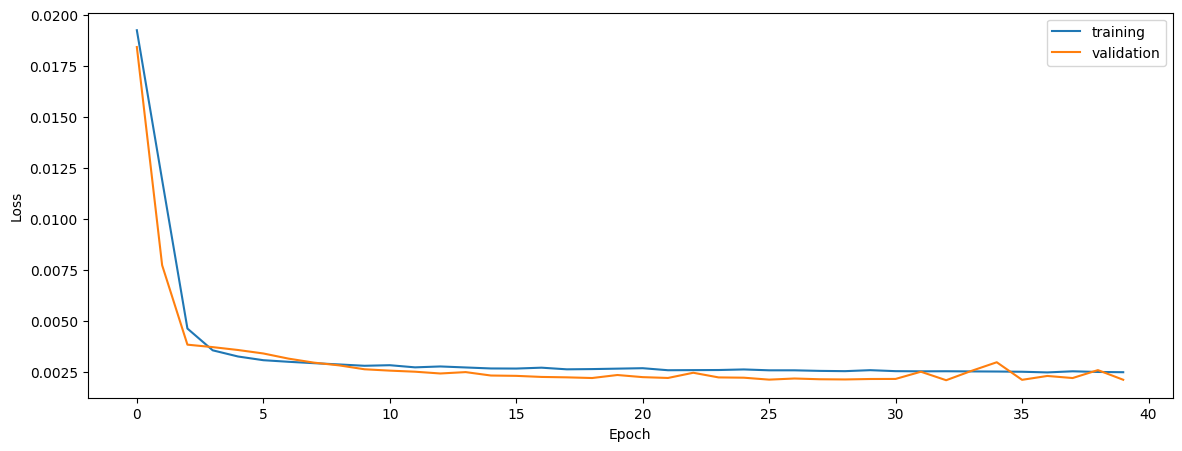

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9221448751171808
0.9455225888491708
0.9547662781606754


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9221448751171808
0.9455225888491708
0.9547662781606754


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.92582570726795
0.9475982482054395
0.9646957017013081


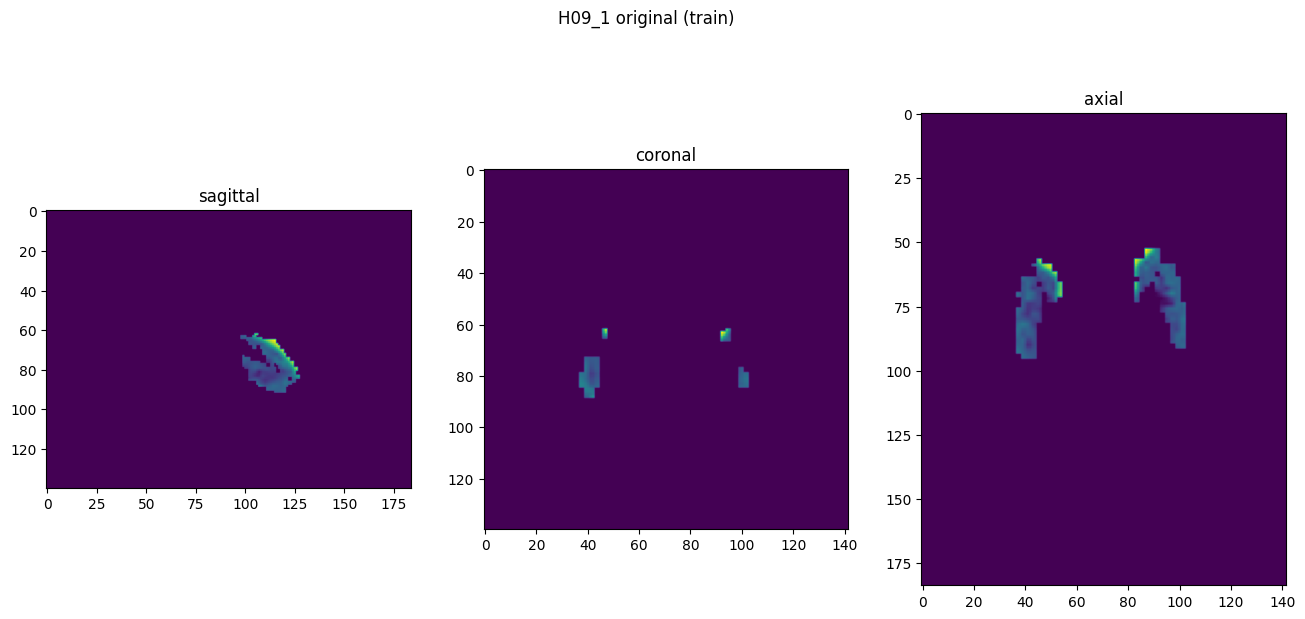

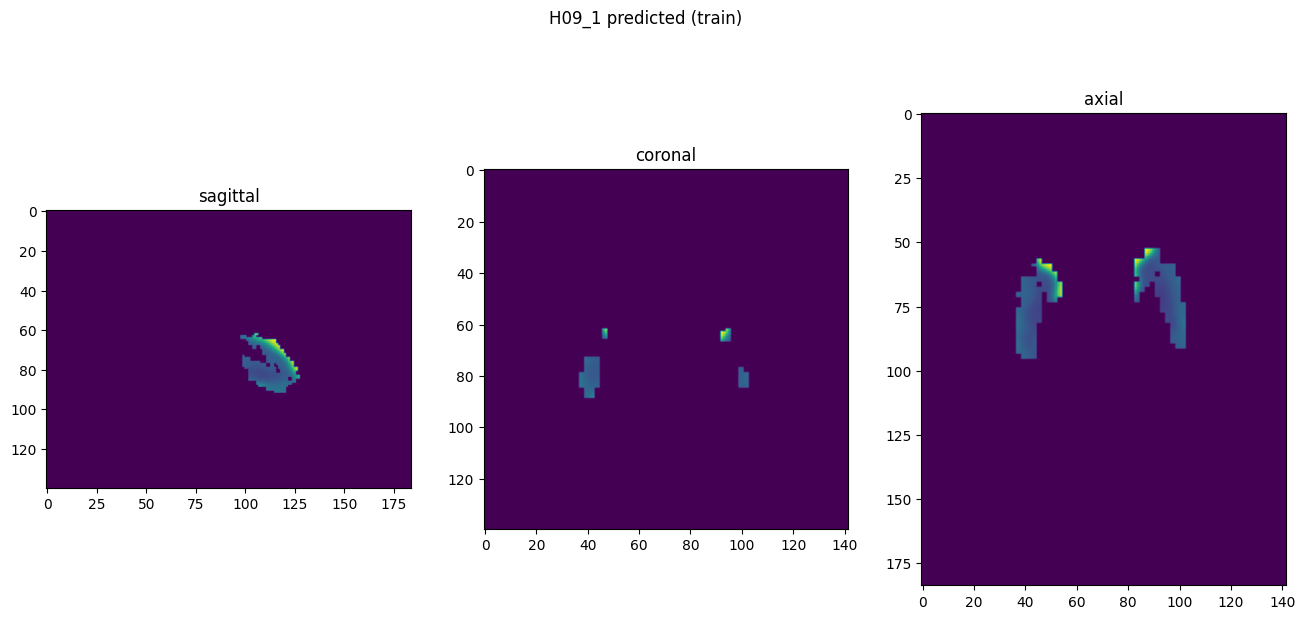

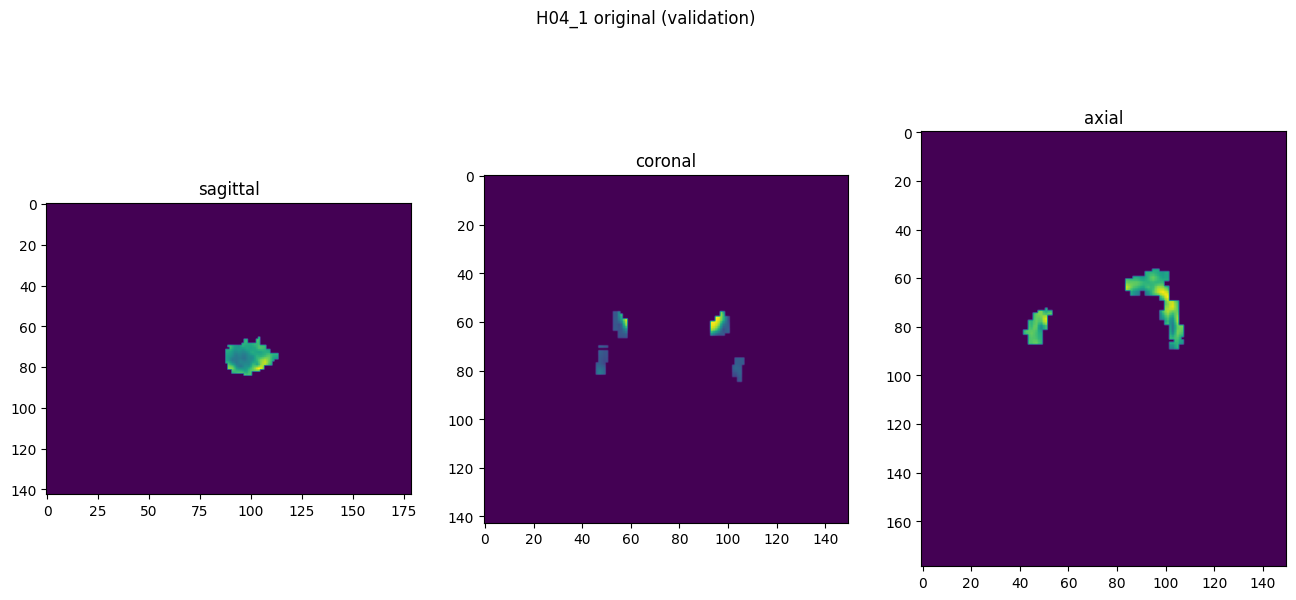

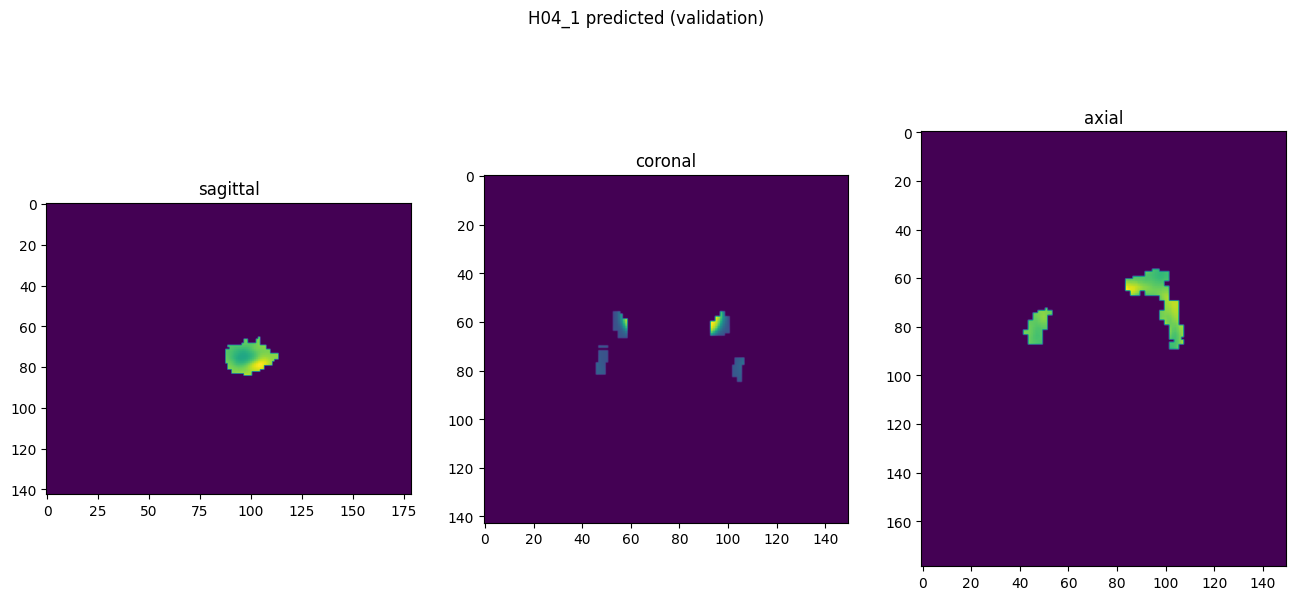

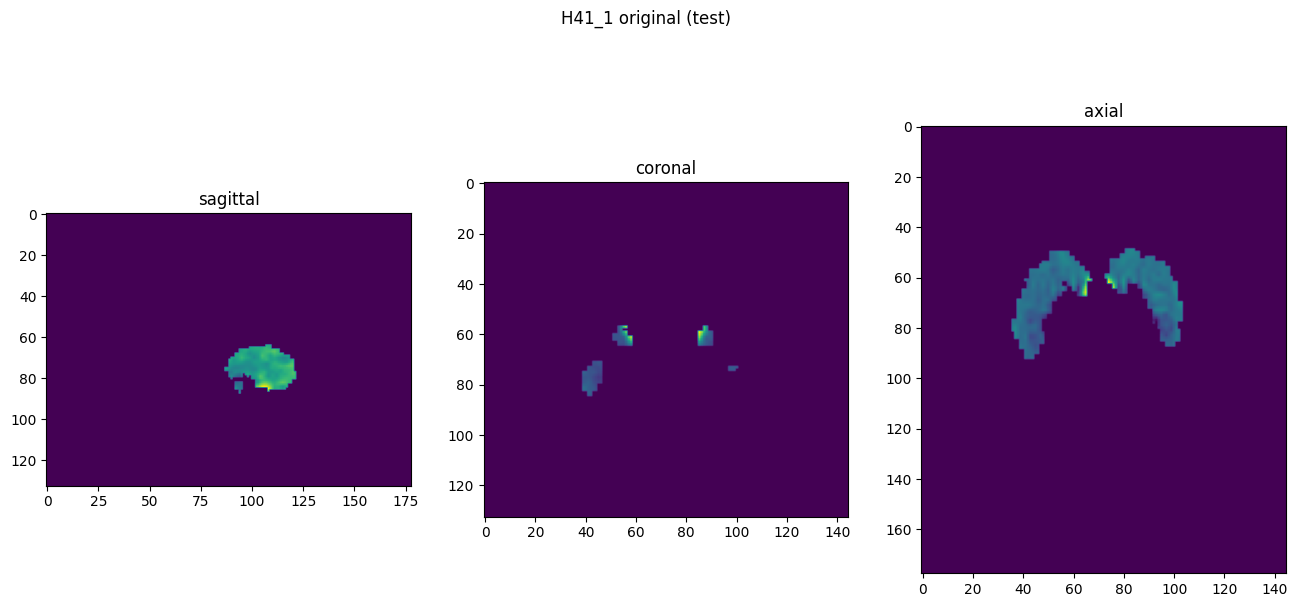

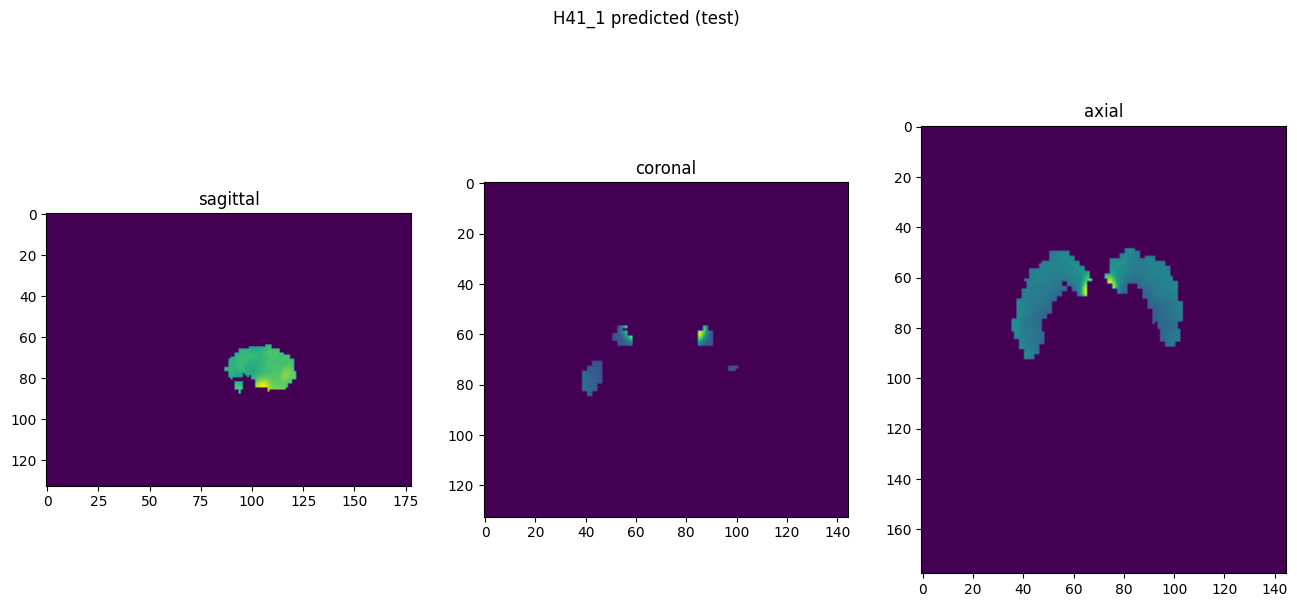

In [10]:
showResults(model, gen, threshold=None, background=False)